In [1]:
import networkx as nx
import dynetx as dn

import ndlib.models.ModelConfig as mc
import ndlib.models.dynamic as dm

import matplotlib
from matplotlib import pyplot as plt
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from networkx.drawing.nx_pylab import draw_networkx

import numpy as np
import pandas as pd
import random

from tqdm import tqdm_notebook as tqdm
import itertools
import pickle

In [196]:
matplotlib.rcParams["figure.figsize"] = [12, 10]

#### build static, scale-free network

In [3]:
g = nx.barabasi_albert_graph(5000, 20)

In [4]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 99600
Average degree:  39.8400


#### set all model parameters

In [278]:
N = g.number_of_nodes()
l = g.number_of_edges()
number_of_iterations = 1000

"""
set contact parameters:
- social distancing starts from the 50th iteration
- lambda denotes the mean active/all contacts ratio in one iteration (drawn from an exponential distribution)
- contacts last for 5 iterations
- no larger ratio of contacts then threshold are set to active in one iteration
"""

social_distancing_range = range(50, 501)
normal_lambda = 0.1
social_dist_lambda = 0.001
contact_duration = 5
threshold = 0.5

"""
basic units of society: families, public places (schools, work, groceries, etc.), and larger gatherings 
are handled separately from other contacts:
- places_lambda stands for the mean ratio of interactions within a given public place
 (drawn from an exponential distribution)
- places_shutdown determines the ratio to which public interactions are reduced after social distancing
- parties_lambda denotes the mean attendance ratio of parties (drawn from an exponential distribution)
"""

number_of_families = 500
number_of_places = 100
places_lambda = 0.01
places_shutdown = 0.01
parties_lambda = 0.01

#### find all cliques

In [6]:
all_cliques = (
    pd.DataFrame([[set(c), len(c)] for c in nx.enumerate_all_cliques(g) if len(c) > 2])
    .rename(columns={0: "clique", 1: "size"})
    .groupby("size")
    .apply(lambda df: list(df["clique"]))
    .to_dict()
)

In [7]:
all_cliques.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11])

In [8]:
def find_clique_edges(cliques):

    return set(
        sum(
            [
                [frozenset(c) for c in itertools.combinations(clique, r=2)]
                for clique in cliques
            ],
            [],
        )
    )

#### designate families and interactions in public places

In [9]:
families = find_clique_edges(
    random.sample(sum([all_cliques[s] for s in range(4, 6)], []), number_of_families)
)

In [10]:
public_places = (
    find_clique_edges(
        [
            random.sample(g.nodes(), int(N * np.random.exponential(places_lambda)))
            for p in range(number_of_places)
        ]
    )
    - families
)

#### build dynamic network

In [273]:
dg = dn.DynGraph(edge_removal=True)

In [274]:
dg.add_nodes_from(g.nodes)

#### add families and public interactions

In [275]:
dg.add_interactions_from([list(f) for f in families], t=0, e=number_of_iterations)

In [279]:
dg.add_interactions_from(
    [list(p) for p in public_places], t=0, e=social_distancing_range[0]
)

In [280]:
dg.add_interactions_from(
    [
        list(p)
        for p in random.sample(public_places, int(len(public_places) * places_shutdown))
    ],
    t=social_distancing_range[0],
    e=social_distancing_range[-1],
)

In [284]:
dg.add_interactions_from(
    [list(p) for p in public_places],
    t=social_distancing_range[-1],
    e=number_of_iterations,
)

In [285]:
print(nx.info(dg))

Name: 
Type: DynGraph
Number of nodes: 5000
Number of edges: 271917
Average degree: 108.7668


In [282]:
print(nx.info(dg.time_slice(t_from=50, t_to=60)))

Name: 
Type: DynGraph
Number of nodes: 2468
Number of edges: 4293
Average degree:   3.4789


In [294]:
print(nx.info(dg.time_slice(t_from=600, t_to=610)))

Name: 
Type: DynGraph
Number of nodes: 5000
Number of edges: 352585
Average degree: 141.0340


#### add contacts and parties

In [86]:
potential_edges = set([frozenset(e) for e in g.edges]) - families - public_places

In [287]:
for i in tqdm(range(number_of_iterations)):

    ### add basic contacts

    _lambda = social_dist_lambda if (i in social_distancing_range) else normal_lambda

    new_contacts = set(
        random.sample(
            potential_edges, int(min(np.random.exponential(_lambda), threshold) * l)
        )
    )

    ### add large gatherings

    if i not in social_distancing_range:

        parties = set(
            find_clique_edges(
                [random.sample(g.nodes, int(N * np.random.exponential(parties_lambda)))]
            )
        ).intersection(potential_edges)

    else:
        parties = set()

    all_contacts = [list(c) for c in new_contacts.union(parties)]

    for c in all_contacts:
        try:
            dg.add_interaction(
                c[0], c[1], t=i, e=i + contact_duration,
            )
        except:
            pass

In [289]:
print(nx.info(dg))

Name: 
Type: DynGraph
Number of nodes: 5000
Number of edges: 367764
Average degree: 147.1056


In [290]:
dg.time_slice(t_from=10, t_to=10).number_of_edges()

313390

In [293]:
dg.time_slice(t_from=100, t_to=110).number_of_edges()

5441

In [295]:
dg.time_slice(t_from=600, t_to=610).number_of_edges()

352585

In [296]:
pickle.dump(dg, open("dynamic_network_relapse.p", "wb"))

#### build SIR model

In [297]:
model = dm.DynSIRModel(dg)

In [299]:
config = mc.Configuration()
config.add_model_parameter("fraction_infected", 0.05)
config.add_model_parameter("beta", 0.005)
config.add_model_parameter("gamma", 0.005)
model.set_initial_status(config)

In [300]:
iterations = model.execute_snapshots()

In [301]:
trends = model.build_trends(iterations)

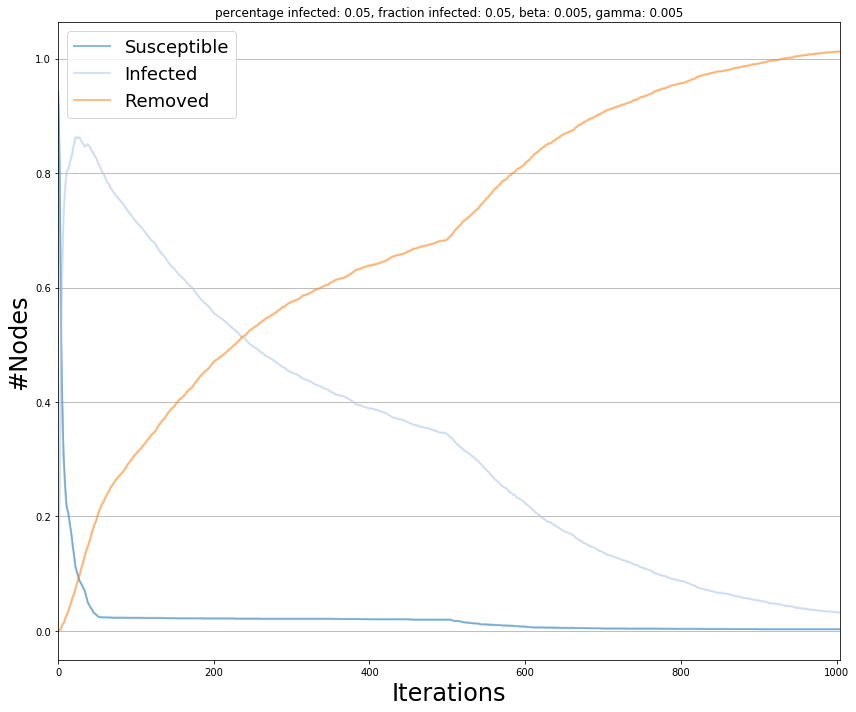

In [302]:
DiffusionTrend(model, trends).plot()

In [269]:
pickle.dump(iterations, open("iterations_relapse.p", "wb"))

In [270]:
pickle.dump(trends, open("trends_relapse.p", "wb"))

In [303]:
susceptible = trends[0]["trends"]["node_count"][0]
infected = trends[0]["trends"]["node_count"][1]
removed = trends[0]["trends"]["node_count"][2]

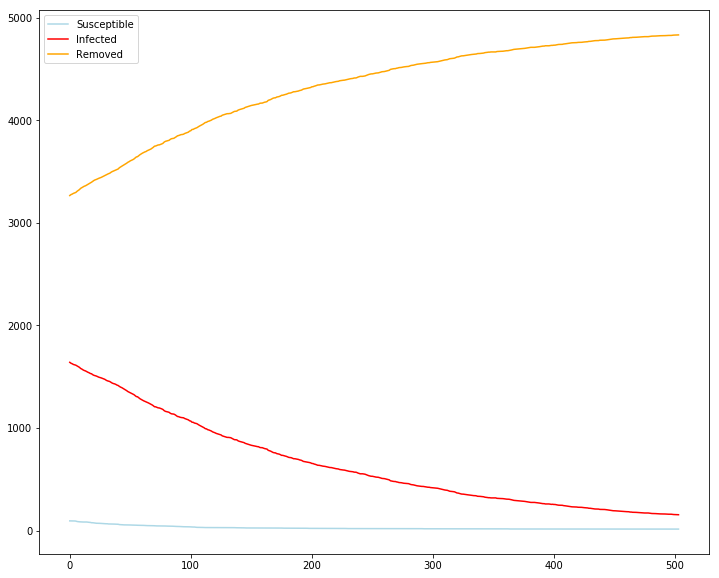

In [306]:
plt.plot(susceptible[500:], c="lightblue", label="Susceptible")
plt.plot(infected[500:], c="red", label="Infected")
plt.plot(removed[500:], c="orange", label="Removed")
plt.legend()